<ipython-input-2-264f1372a870>:8: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  matches["date"] = pd.to_datetime(matches["date"])


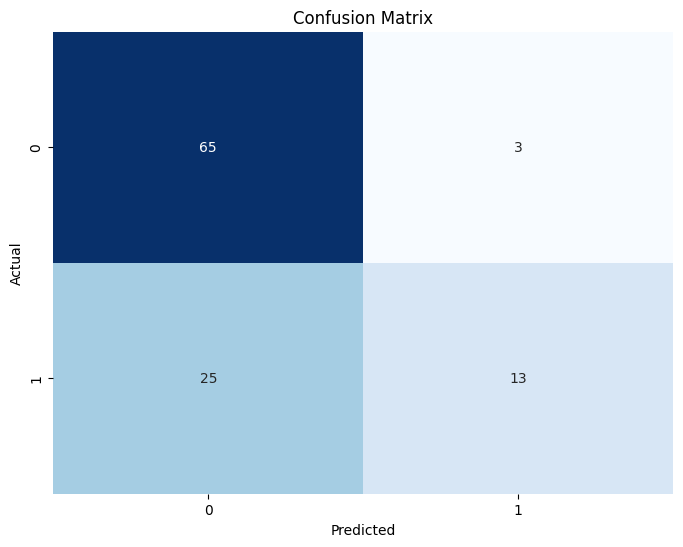

Accuracy: 0.7358490566037735
Precision: 0.8125


In [2]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
matches = pd.read_csv("matches.csv", index_col=0)
del matches["comp"], matches["notes"]
matches["date"] = pd.to_datetime(matches["date"])
matches["target"] = (matches["result"] == "W").astype("int")
matches["venue_code"] = matches["venue"].astype("category").cat.codes
matches["opp_code"] = matches["opponent"].astype("category").cat.codes
matches["day_code"] = matches["date"].dt.dayofweek
from sklearn.ensemble import RandomForestClassifier
#rf = RandomForestClassifier(n_estimators=50, min_samples_split=2, random_state=42)
svm = SVC(kernel='rbf', C=1.0, random_state=42)
from sklearn.metrics import accuracy_score, precision_score
grouped_matches = matches.groupby("team")
group = grouped_matches.get_group("Arsenal").sort_values("date")
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("date")
    rolling_stats = group[cols].rolling(3, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group
cols = ["gf", "ga", "sh", "sot", "dist", "fk", "pk", "pkatt"]
new_cols = [f"{c}_rolling" for c in cols]
rolling_averages(group, cols, new_cols)
matches_rolling = matches.groupby("team").apply(lambda x: rolling_averages(x, cols, new_cols))
matches_rolling = matches_rolling.droplevel('team')
matches_rolling.index = range(matches_rolling.shape[0])
predictors = ["venue_code", "opp_code", "day_code", "gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling" ]
#predictors = ["venue_code", "opp_code", "day_code" ]
#predictors = ["gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling" ]
def make_predictions(data, predictors):
    train = data[data["date"] < '2024-01-01']
    test = data[data["date"] > '2024-01-01']
    #rf.fit(train[predictors], train["target"])
    #preds = rf.predict(test[predictors])
    svm.fit(train[predictors], train["target"])
    preds = svm.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test["target"], predicted=preds), index=test.index)
    accuracy = accuracy_score(test["target"], preds)
    precision = precision_score(test["target"], preds)
    conf_matrix = confusion_matrix(combined["actual"], combined["predicted"])
    return combined, accuracy, precision, conf_matrix
combined, accuracy, precision, conf_matrix= make_predictions(matches_rolling, predictors)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("Accuracy:", accuracy)
print("Precision:",precision)

In [ ]:
combined = combined.merge(matches_rolling[["date", "team", "opponent", "result"]], left_index=True, right_index=True)

In [ ]:
combined.head(10)

,actual,predicted,date,team,opponent,result
58,1,1,2024-04-02,Arsenal,Liverpool,W
59,1,0,2024-11-02,Arsenal,West Ham,W
118,1,0,2024-03-02,Aston Villa,Sheffield Utd,W
119,0,0,2024-11-02,Aston Villa,Manchester Utd,L
177,0,0,2024-04-02,Bournemouth,Nott'ham Forest,D
178,0,0,2024-10-02,Bournemouth,Fulham,L
237,0,0,2024-05-02,Brentford,Manchester City,L
238,1,0,2024-10-02,Brentford,Wolves,W
297,1,1,2024-03-02,Brighton and Hove Albion,Crystal Palace,W
298,0,1,2024-10-02,Brighton and Hove Albion,Tottenham,L


In [ ]:
combined.to_csv("matches_predicted.csv")